## Goals:
- make a histogram of the lepton pt as a regular variable,  the "cut" as a string category, the Z boson pt as another regular variable and finally the deltaR(Z boson, lepton) as another regular variable
- save each of the selection cuts currently applied now as different masks
- for each mask save the candidate lepton pT distribution in the histogram, save the cut in the string category, and save the Z boson pt, and the deltaR(z boson, candidate lepton)
- for the Z boson pT you can do something similar to our gen matching i.e. find the Z boson gen particle in the event

In [1]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# import uproot
# f = uproot.open(f"../datafiles/DYJetsToLL_Pt-50To100.root")
# num = f['Events'].num_entries   ### checks number of events per file 
# print(f'number of events per file is {num}')

# events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()

In [10]:
# define the configuration and processor
flag = "DYJetsToLL_Pt-400To650"
fileset = {}

dataset = ["DYJetsToLL_Pt-50To100","DYJetsToLL_Pt-100To250", "DYJetsToLL_Pt-250To400", "DYJetsToLL_Pt-400To650", "DYJetsToLL_Pt-650ToInf" ]
for data in dataset:
    if flag == data:
        fileset[flag] = [f"../datafiles/{flag}.root"]

outfiles = "./" + flag + "/"

job_name = '/0-1'
channels=['ele', 'mu', 'had']

from boostedhiggs.hwwprocessor_nocuts import HwwProcessor_nocuts
p = HwwProcessor_nocuts(year='2017', channels=channels, output_location=outfiles + job_name)

In [11]:
# remove output directory to store fresh samples
if os.path.exists(outfiles):
    shutil.rmtree(outfiles)

In [12]:
executor = processor.IterativeExecutor(status=True)
run = processor.Runner(
    executor=executor, savemetrics=True, schema=nanoevents.NanoAODSchema, chunksize=10000
)
    
out, metrics = run(
fileset, "Events", processor_instance=p
)

# dump to pickle
filehandler = open(outfiles + job_name + '.pkl', "wb")
pkl.dump(out, filehandler)
filehandler.close()

# merge parquet
for ch in channels:
    data = pd.read_parquet(outfiles + job_name + ch + '/parquet')
    data.to_parquet(outfiles + job_name + '_' + ch + '.parquet')

    # remove old parquet files
    os.system('rm -rf ' + outfiles + job_name + ch)
    
    data_jets = pd.read_parquet(outfiles + job_name + '/jets/' + ch + '/parquet')
    data_jets.to_parquet(outfiles + job_name + '_jets_' + ch + '.parquet')

# remove old parquet files
os.system('rm -rf ' + outfiles + job_name)    
    

data = {}
data_jets = {}
for ch in channels:  
    data[ch] = pq.read_table(outfiles + job_name + '_' + ch + '.parquet').to_pandas()
    data_jets[ch] = pq.read_table(outfiles + job_name + '_jets_' + ch + '.parquet').to_pandas()

with open(outfiles + job_name + '.pkl', 'rb') as f:
    metadata = pkl.load(f)

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

/opt/anaconda3/envs/coffea-env/lib/python3.7/site-packages/awkward/_connect/_numpy.py:210: RuntimeWarning: divide by zero encountered in log
  *[nplike.asarray(x) for x in inputs], **kwargs


In [6]:
data['ele']

,lep_pt,lep_isolation,lep_misolation,lep_fj_m,lep_fj_bjets_ophem,lep_fj_dr,fj_msoftdrop,fj_pt,lep_met_mt,met,...,MuonIsolation,ElectronIsolation,leptonInJet,anti_bjettag,mt_lep_met,oneFatjet,fatjetKin,fatjetSoftdrop,qcdrho,jets_outside_btag_max
0,643.694702,0.000071,0.000000,35.584927,0.705078,0.035760,0.113342,746.50,196.644501,70.650093,...,1,1,1,0,0,False,795.5,0,0,0.060364
1,317.285980,1.251853,0.000000,45.952419,0.183594,0.162858,114.062500,778.50,306.120117,76.124092,...,1,1,1,1,0,False,778.5,0,1,0.183594
2,766.245300,0.403529,0.000000,81.394875,0.162231,0.001465,27.609375,1193.00,1099.670044,394.856506,...,1,1,1,1,0,False,1193.0,0,0,0.162231
3,429.051331,0.000657,0.010792,47.429390,0.013168,0.091875,100.687500,743.50,27.273905,84.274734,...,1,1,1,1,1,False,743.5,0,1,0.120728
4,704.840332,0.004815,0.005891,30.416210,0.025879,0.030615,0.264893,811.50,217.631638,18.928827,...,1,1,1,1,0,False,811.5,0,0,0.068115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23488,745.107849,0.000000,0.000000,29.328054,0.021530,0.039765,103.812500,898.50,427.570251,61.550861,...,1,1,1,1,0,False,898.5,0,1,0.065552
23489,256.606873,0.015353,0.000000,27.870152,0.077820,0.063646,40.218750,392.25,28.528660,182.075256,...,1,1,1,1,1,False,521.0,0,0,0.461426
23490,386.114899,0.000843,0.000000,37.440830,0.032410,0.119831,100.687500,743.50,6.533151,82.433701,...,1,1,1,1,1,False,769.5,0,0,0.062439
23491,334.298370,0.006160,0.000000,45.180195,0.014656,0.124308,101.500000,1096.00,270.826599,57.965065,...,1,1,1,1,0,False,1096.0,0,1,0.381836


## 1D-histogram with single axis:

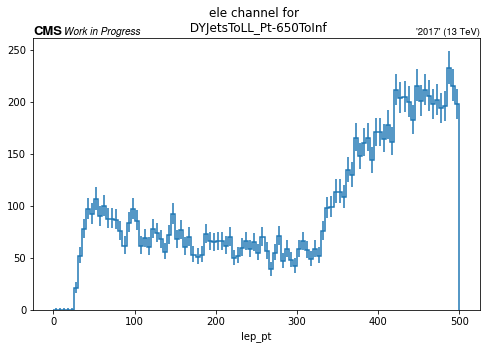

In [7]:
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
)
h.fill(data['ele']['lep_pt']
      )

odir = flag + '/jets'
fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot(h, ax=ax)
# ax.set_xlabel(f"{'btag_max'}")
ax.set_title(f'ele channel for \n {flag}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/lep_pt_wth_btag_threshold.pdf')
plt.show()
plt.close()

In [8]:
h = hist2.Hist(
    hist2.axis.Regular(100,0, 1, name='btag_max', label='btag_max', flow=True),
)
h.fill(data['ele']['jets_outside_btag_max']
      )

odir = flag + '/jets'
fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot(h, ax=ax)
ax.set_xlabel(f"{'btag_max'}")
ax.set_title(f'ele channel for \n {flag}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)

if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/btag_max.pdf')
plt.close()

## 1D-histogram with multiple axes:

In [9]:
h = hist2.Hist(
    hist2.axis.Regular(100,0, 1, name='btag', label='btag', flow=True),
    hist2.axis.StrCategory([], name='channel', growth=True),
)
for ch in channels:
    h.fill(data_jets[ch], ch
    )

ValueError: All arrays must be 1D

In [ ]:
odir = flag + '/jets'
for ch in h.axes[-1]:
    fig, ax = plt.subplots(figsize=(8, 5))
    hep.histplot(h[{'channel': ch}], ax=ax)
    ax.set_xlabel(f"{'btag'}")
    ax.set_title(f'{ch} channel for \n {flag}')
    hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)

    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/btag_{ch}.pdf')
    plt.close()

In [ ]:
data['ele'].keys()

## 2D-plots:

In [ ]:
# Z_pt vs lep_Z_dr
h = hist2.Hist(
    hist2.axis.Regular(100,0, 2, name='lep_Z_dr', label='lep_Z_dr', flow=True),
    hist2.axis.Regular(100,0, 500, name='Z_pt', label='Z_pt', flow=True),
    hist2.axis.StrCategory([], name='channel', growth=True),
)
for ch in channels:
    if ch != 'had':    
        h.fill(data[ch]['lep_Z_dr'], data[ch]['Z_pt'], ch
        )
    
odir = flag + '/jets'
for ch in h.axes[-1]:
    fig, ax = plt.subplots(figsize=(8, 5))
    hep.hist2dplot(h[{'channel': ch}], ax=ax)
    ax.set_xlabel(f"{'lep_Z_dr'}")
    ax.set_ylabel(f"{'Z_pt'}")    
    ax.set_title(f'{ch} channel for \n {flag}')
    hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)

    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/Z_pt_&_lep_Z_dr_{ch}.pdf')
    plt.close()

In [ ]:
# btag_max vs lep_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 0.8, name='btag_max', label='btag_max', flow=True),
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),
    hist2.axis.StrCategory([], name='channel', growth=True),
)
for ch in channels:
    if ch != 'had':        
        h.fill(data[ch]['jets_outside_btag_max'], data[ch]['lep_pt'], ch
        )
    
odir = flag + '/jets'
for ch in h.axes[-1]:
    fig, ax = plt.subplots(figsize=(8, 5))
    hep.hist2dplot(h[{'channel': ch}], ax=ax)
    ax.set_xlabel(f"{'btag_max'}")
    ax.set_xlabel(f"{'lep_pt'}")    
    ax.set_title(f'{ch} channel for \n {flag}')
    hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
    hep.cms.text("Work in Progress", ax=ax)

    if not os.path.exists(f'{odir}/'):
        os.makedirs(f'{odir}/')

    plt.savefig(f'{odir}/lep_pt_&_btag_max_{ch}.pdf')
    plt.close()

In [ ]:
# taus vs notaus
h = hist2.Hist(
    hist2.axis.Regular(100,0, 0.8, name='btag_max', label='btag_max', flow=True),
   hist2.axis.StrCategory([], name='taus_status', growth=True),
)
h.fill(data['mu']['jets_outside_btag_max'][data['mu']['notaus_mu']], 'notaus_True'
)
h.fill(data['mu']['jets_outside_btag_max'][data['mu']['notaus_mu']==False], 'notaus_False'
)

In [ ]:
h[{'taus_status': 'notaus_True'}]

In [ ]:
h[{'taus_status': 'notaus_False'}]

In [ ]:
odir = flag + '/jets'
fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot(h[{'taus_status': 'notaus_True'}], ax=ax, label='notaus_True')
hep.histplot(h[{'taus_status': 'notaus_False'}], ax=ax, label='notaus_False')
ax.set_xlabel(f"{'btag_max'}")
ax.set_title(f'mu channel for \n {flag} notaus_True')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax)
ax.legend()
if not os.path.exists(f'{odir}/'):
    os.makedirs(f'{odir}/')

plt.savefig(f'{odir}/taus_btag_max_mu.pdf')
plt.close()

## Cut histograms:

In [ ]:
# make the cuts
cuts = {}

cuts['ele'] = {'leptonKin': data['ele']['leptonKin']>40, 
               'oneElectron': data['ele']['oneElectron'],
               'notaus_ele': data['ele']['notaus_ele'],
               'ElectronIsolation': data['ele']['ElectronIsolation']==1,               
               'leptonInJet': data['ele']['leptonInJet']==1,
               'anti_bjettag': data['ele']['anti_bjettag']==1,
               'ht': data['ele']['ht'],
               'mt_lep_met': data['ele']['mt_lep_met']==1,               
              }

cuts['mu'] = {'leptonKin': data['mu']['leptonKin']>30, 
               'oneMuon': data['mu']['oneMuon'],
               'notaus_mu': data['mu']['notaus_mu'],
               'MuonIsolation': data['mu']['MuonIsolation']==1,                             
               'leptonInJet': data['mu']['leptonInJet']==1,
               'anti_bjettag': data['mu']['anti_bjettag']==1,
               'ht': data['mu']['ht'],
               'mt_lep_met': data['mu']['mt_lep_met']==1,               
              }

cuts['had'] = {'oneFatjet': data['had']['oneFatjet'], 
               'fatjetKin': data['had']['fatjetKin']>300,
               'fatjetSoftdrop': data['had']['fatjetSoftdrop']==1,
               'qcdrho': data['had']['qcdrho']==1,                             
               'met': data['had']['met']<200,            
              }

In [ ]:
hists = {}
year = '2017'
channels = ['ele', 'mu']

hists[year] = {}
for ch in channels:

    hists[year][ch] = hist2.Hist(
        hist2.axis.Regular(50,0, 250, name='lepton_pt', label='lepton_pt', flow=True),
        hist2.axis.StrCategory([], name='cuts', growth=True)
    )

# loop over the cuts and fill the histograms
for ch in channels:
    for key, value in cuts[ch].items():
        hists[year][ch].fill(
            data[ch][value]['lep_pt'], key,
        )

In [ ]:
flag

In [ ]:
odir = flag + '/plots_single_cut'
# remove output directory to store fresh samples
if os.path.exists(f'{odir}'):
    shutil.rmtree(f'{odir}')
for ch in channels:
    for cut in hists[year][ch].axes[-1]:
        fig, ax = plt.subplots(figsize=(8, 5))
        hep.histplot(hists[year][ch][{'cuts': cut}], ax=ax)
        ax.set_xlabel(f"{'lep_pt'}")
        ax.set_title(f'{ch} channel after \n {cut} cut')
        hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
        hep.cms.text("Work in Progress", ax=ax)

        if not os.path.exists(f'{odir}/'):
            os.makedirs(f'{odir}/')

        plt.savefig(f'{odir}/{ch}_{cut}.pdf')
        plt.close()

In [ ]:
odir = flag + '/plots_all_cuts'
# remove output directory to store fresh samples
if os.path.exists(f'{odir}'):
    shutil.rmtree(f'{odir}')
for ch in channels:
        fig, ax = plt.subplots(figsize=(8, 5))
        for cut in hists[year][ch].axes[-1]:        
            hep.histplot(hists[year][ch][{'cuts': cut}], ax=ax, label=cut)
        
        ax.set_xlabel(f"{'lep_pt'}")
        ax.set_title(f'{ch} channel for sample \n {flag}')
        hep.cms.lumitext(f"{year} (13 TeV)", ax=ax)
        hep.cms.text("Work in Progress", ax=ax)

        if not os.path.exists(f'{odir}/'):
            os.makedirs(f'{odir}/')
        ax.legend()
        plt.savefig(f'{odir}/{ch}_{cut}.pdf')
        plt.close()